# Generate Manhattan Plots and LM plots for 1 SNP

## IMPORTS & FUNCTIONS

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
sns.set_theme(style="whitegrid")
pheno = pd.read_csv("../Ressources/pheno.csv")
pheno = pheno[["HybID","NSFTVID","Seed.number.per.panicle","Amylose.content","Straighthead.suseptability"]]
geno = pd.read_csv("../Ressources/geno.csv")
genoMat = geno[[str(i) for i in range(1,414)]]

In [245]:
def getModel(X,Y):
    X2 = sm.add_constant(X)
    mod = sm.OLS(Y,X2,missing="raise")
    fii = mod.fit()
    return mod,fii

def getPValues(fii):
    return fii.summary2().tables[1]["P>|t|"]

def plotManhattan(genes,pvalues,chromosomes,colname,title="test plot",ymax=15):
    """
    Generate and save manhattan plot
    
    genes: list of genes indexes
    pvalues: list of the p-values corresponding to the genes
    chromosomes: list of the chromosomes corresponding to the genes
    title: title of the plot
    savepath: path where the plot is saved
    """
    df = pd.DataFrame(
        {
            'gene' : genes,
            'pvalue' : pvalues,
            'chromosome' : chromosomes
        })
    
    # -log_10(pvalue)
    nbchrom = len(df.chromosome.unique())
    df['minuslog10pvalue'] = -np.log10(df.pvalue)
    df.chromosome = df.chromosome.astype('category')
    df.chromosome = df.chromosome.cat.set_categories(['ch-%i' % i for i in range(1,nbchrom+1)], ordered=True)
    df = df.sort_values('chromosome')

    # How to plot gene vs. -log10(pvalue) and colour it by chromosome?
    df['ind'] = range(len(df))
    df_grouped = df.groupby(('chromosome'))

    # manhattan plot
    fig = plt.figure(figsize=(14, 8)) # Set the figure size
    
    
    ax = fig.add_subplot(111)
    colors = ['gold','deepskyblue','hotpink', 'limegreen']
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='minuslog10pvalue',color=colors[num % len(colors)], ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)

    # set axis limits
    bonfcorrLimit = -np.log10(0.01/df.shape[0])
    print(bonfcorrLimit)
    ax.set_xlim([0, len(df)])
    #ax.set_ylim([0, max(df["minuslog10pvalue"].max(),bonfcorrLimit+0.5)])
    ax.set_ylim([0, ymax])

    # x axis label
    ax.set_xlabel('Chromosome')
    
    # Significant genes separation with bonferroni correction
    plt.axhline(y = bonfcorrLimit, color = 'r', linestyle = '-', label='separation with Bonferroni correction')

    # show the graph
    plt.title(title, y=-0.2)
    plt.legend()
    savepath=f"manhattan_{colname.replace('.','_')}.png"
    plt.savefig('manhattan_test.png')
    plt.show()

def plotPhenoGeno2(i,colName):
    Y = pd.Series(list(pheno[colName]),name="Y")
    X = pd.Series(list(genoMat.loc[i]),name="X")
    df=pd.concat([X,Y],axis=1)
    df.dropna(inplace=True)

    fig, axs = plt.subplots(ncols=2, figsize=(8,6))
    # Draw a nested violinplot and split the violins for easier comparison
    colorDict = {
        0:"deepskyblue",
        1:"hotpink",
        2:"limegreen"
    }
    sns.violinplot(data=df, x="X", y="Y", cut=0,
                   split=True, inner="quart", linewidth=2,ax=axs[0],palette=colorDict)
    g = sns.regplot(
    data=df, x="X", y="Y",
    scatter=True, truncate=False, order=1,scatter_kws={"color":"black"},ax=axs[1]
    )
    axs[0].set_ylabel(colName.replace("."," "))
    axs[1].set_ylabel("")
    axs[0].set_xlabel("SNP value")
    axs[1].set_xlabel("SNP value")
    fig.suptitle(f'SNP n°{i+1} analysis with linear model', fontsize=16)
    
    # Calculate number of obs per group & median to position labels
    medians = df.groupby(['X']).median().sort_index().values
    nobs = df['X'].value_counts().sort_index().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    
    # Add text to the figure
    pos = range(len(nobs))
    for tick, label in zip(pos, axs[0].get_xticklabels()):
       axs[0].text(pos[tick], medians[tick] + 0.03, nobs[tick],
                horizontalalignment='center',
                size='small',
                color='w',
                weight='semibold')
    plt.show()

def computePValues(phenoColumnName,genoMat):
    pvalues = []
    Y = pd.Series(list(pheno[phenoColumnName]),name="Y")
    for i in tqdm(range(genoMat.shape[0])):
        X = pd.Series(list(genoMat.loc[i]),name="X")
        df=pd.concat([X,Y],axis=1)
        df.dropna(inplace=True)
        mod,fii = getModel(df["X"],df["Y"])
        pvalues.append(getPValues(fii)["X"])
    return pvalues

def saveMdf(genes,pvalues,chromosomes,name="manhattanDF"):
    df = pd.DataFrame(
        {
            'gene' : genes,
            'pvalue' : pvalues,
            'chromosome' : chromosomes
        })
    df.to_csv(f"{name}.csv")
    return df

def saveAllManhattanDf(pheno,geno):
    genes = geno["marker"]
    chromosomes = pd.Series([f"ch-{i}" for i in geno["chrom"]])
    genoMat = geno[[str(i) for i in range(1,414)]]
    res = {}
    for col in pheno.columns[2:]:
        pvalues = computePValues(col,genoMat)
        res[col] = saveMdf(genes,pvalues,chromosomes,name=f"manhattan_{col.replace('.','_')}")
    return res

def getBestPValues(pvalues,maxpvalue,minpvalue):
    m = []
    for i in range(len(pvalues)):
        mtmp = -np.log10(pvalues[i])
        if mtmp>minpvalue and mtmp<maxpvalue:
            m.append((mtmp,i))
    m = sorted(m, key = lambda x: x[0],reverse=True)
    return m

def separateInGroups(snpId,trait="Seed.number.per.panicle"):
    g = []
    i=0
    for al in genoMat.loc[snpId]:
        value = pheno[trait][i]
        if value == value:
            if al == 2:
                g.append({
                    "group":2,
                    "accession":i,
                    trait:value
                })
            else:
                g.append({
                    "group":1,
                    "accession":i,
                    trait:value
                })
        i+=1
    return g

def aux(val,isDominantAdv):
    return (val == 2 and isDominantAdv) or (val == 0 and not isDominantAdv)

def countAdvantageous(snpIdList,trait="Seed.number.per.panicle"):
    data = pd.DataFrame(pheno[trait])
    for snpId in snpIdList:
        g = genoMat.loc[snpId].groupby(lambda x: genoMat.loc[snpId][x])
        mean = g.mean()
        isDominantAdvantageous = mean[2]>mean[0]
        data[snpId]=np.fromiter((aux(genoMat.loc[snpId][i],isDominantAdvantageous) for i in range(413)),int)
    return data

def identifyGroupsBasedOnAdv(pvalList,trait="Amylose.content",nbGroups=2,isHigherAdvantageous=True):
    data = countAdvantageous(pvalList,trait=trait)
    data["total"]=data[pvalList].sum(axis=1)
    #data['group']=data_amylose["total"]>=data_amylose["total"].quantile(q = 0.99)
    
    if nbGroups==4:
        data['group'] = pd.qcut(data['total'].rank(method='first'), 4,labels=["Not advantageous","Normal","Advantageous","Really advantageous"][::[-1,1][isHigherAdvantageous]])
    elif nbGroups==3:
        data['group'] = pd.qcut(data['total'].rank(method='first'), 3,labels=["Not advantageous","Advantageous","Really advantageous"][::[-1,1][isHigherAdvantageous]])
    else:
        data['group'] = pd.qcut(data['total'].rank(method='first'), 2,labels=["Not advantageous","Advantageous"][::[-1,1][isHigherAdvantageous]])
    
    fig, axs = plt.subplots(ncols=2, figsize=(16,6))
    # Draw a nested violinplot and split the violins for easier comparison
    colorDict = {
        "Not advantageous":"deepskyblue",
        "Advantageous":"limegreen",
        "Really advantageous":"hotpink",
        "Normal":"gold"
    }
    violinGroups = sns.violinplot(data=data, x="group", y=trait,split=True, inner="quart",cut=0, linewidth=2,ax=axs[0],palette=colorDict)
    sns.regplot(data=data,x="total",y=trait,ax=axs[1], line_kws={"color": "red"})
    axs[1].set(xlabel="Number of advantageous SNPs")
    nobs = [f"n:{i}" for i in data["group"].value_counts()]
    #nobs = [f"n: {data_amylose.shape[0]-data_amylose['group'].sum()}",f"n: {data_amylose['group'].sum()}"]

    #fig.suptitle(f'SNP n° analysis with linear model', fontsize=16)

    # Calculate number of obs per group & median to position labels
    medians = data.groupby(['group']).median().sort_index().values

    for i in range(len(nobs)):
        axs[0].text(i,5,nobs[i],horizontalalignment='center', size='large', color='black', weight='semibold')
    
    return data

## Available DATA

In [3]:
pheno

,HybID,NSFTVID,Seed.number.per.panicle,Amylose.content,Straighthead.suseptability
0,081215-A05,1,4.785975,15.613333,4.833333
1,081215-A06,3,4.439706,23.260000,7.831667
2,081215-A07,4,5.079709,23.120000,NaN
3,081215-A08,5,4.523960,19.323333,8.333333
4,090414-A09,6,5.538646,23.240000,8.166667
...,...,...,...,...,...
408,@52067200649407102410408632092354,21,4.985887,24.763333,8.835000
409,@52067200649407102410408632092363,256,4.354375,18.430000,7.001667
410,@52067200649407102410408632092365,339,4.620507,23.603333,7.501667
411,@52067200649407102410408632092399,133,5.324838,0.395000,5.998333


In [4]:
geno

,Unnamed: 0,marker,chrom,pos,1,2,3,4,5,6,...,404,405,406,407,408,409,410,411,412,413
0,1,id1000001,1,13147,0.0,2.0,2.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
1,2,id1000003,1,73192,0.0,2.0,2.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
2,3,id1000005,1,74969,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,id1000007,1,75852,0.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
4,5,id1000008,1,75953,0.0,2.0,2.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36896,36897,id12010137,12,27440849,0.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0
36897,36898,id12010147,12,27466719,0.0,0.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36898,36899,id12010157,12,27474844,0.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
36899,36900,id12010170,12,27484733,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0


In [91]:
genoMat

,1,2,3,4,5,6,7,8,9,10,...,404,405,406,407,408,409,410,411,412,413
0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
1,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
4,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36896,0.0,2.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0
36897,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36898,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
36899,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0


### Proportions of values in the dataset

In [210]:
values = []
names = ["homozygous dominant (= 2)","heterozygous (= 1)","homozygous recessive (= 0)"]
all = genoMat.shape[0]*genoMat.shape[1]
for n in [0,1,2]:
    x = np.count_nonzero(genoMat.values==n)
    values.append({
        "name":names[n],
        "percentage":f"{round(x*100/all,2)} %",
        "count":f"{x:,}"
    })

x = np.count_nonzero(genoMat.isnull().values==1)
values.append({
        "name":"not defined (= NaN)",
        "percentage":f"{round(x*100/all,2)} %",
        "count":f"{x:,}"
    })
pd.DataFrame(values).set_index("name")

,percentage,count
name,,
homozygous dominant (= 2),66.23 %,"10,093,443"
heterozygous (= 1),0.04 %,"6,009"
homozygous recessive (= 0),29.4 %,"4,479,910"
not defined (= NaN),4.34 %,"660,751"


# Generate and save Manhattan plots

## Generate and save p-values for each characteristic

!!! time consuming

Save p-value for each SNP in a .csv for each trait:
 - manhattan_Seed_number_per_panicle.csv
 - manhattan_Amylose_content.csv
 - manhattan_Straighthead_suseptability.csv

In [102]:
cols = pheno.columns[2:]
print(cols)
#saveAllManhattanDf(pheno,geno)

Index(['Seed.number.per.panicle', 'Amylose.content',
       'Straighthead.suseptability'],
      dtype='object')


In [104]:
df1 = pd.read_csv(f"manhattan_{cols[0].replace('.','_')}.csv")
df2 = pd.read_csv(f"manhattan_{cols[1].replace('.','_')}.csv")
df3 = pd.read_csv(f"manhattan_{cols[2].replace('.','_')}.csv")

## Seed number per panicle

- ne pas oublier de mentionner qu'il y a des SNP qui n'ont que des 0 ou des 2
- ne pas oublier de mentionner qu'il n'y a pas beaucoup d'allèles hétérozygotes dans genoMat (0.04%) d'où une mauvaise séparation entre les allèles significatifs et les autres et d'où la présence d'allèle ayant une pvalue très très petite (mais qui sont invisibles sur les manhattan plots)
- ne pas oublier de mentionner les **facteurs épigénétiques**

   Unnamed: 0       gene    pvalue chromosome
0           0  id1000001  0.086781       ch-1
1           1  id1000003  0.081668       ch-1
2           2  id1000005  0.346586       ch-1
3           3  id1000007  0.235894       ch-1
4           4  id1000008  0.071320       ch-1
6.567038135497739


/home/Arthur/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


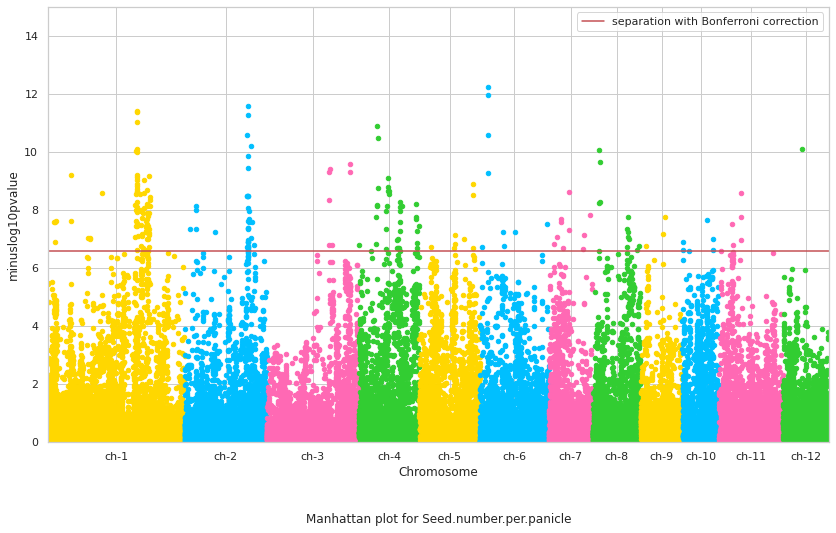

In [106]:
print(df1.head())
plotManhattan(
        df1['gene'],
        df1['pvalue'],
        df1['chromosome'],
        title=f"Manhattan plot for {cols[0]}",
        colname=cols[0],
        ymax=15)

/tmp/ipykernel_126801/2379683092.py:148: RuntimeWarning: divide by zero encountered in log10
  mtmp = -np.log10(pvalues[i])


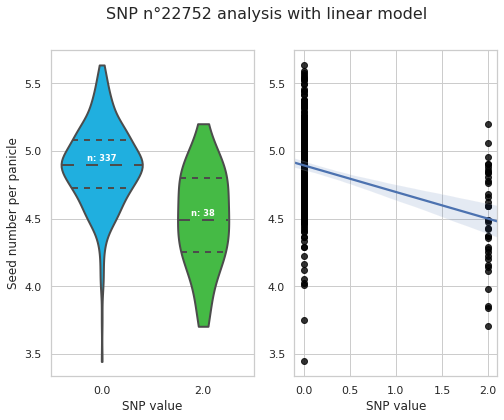

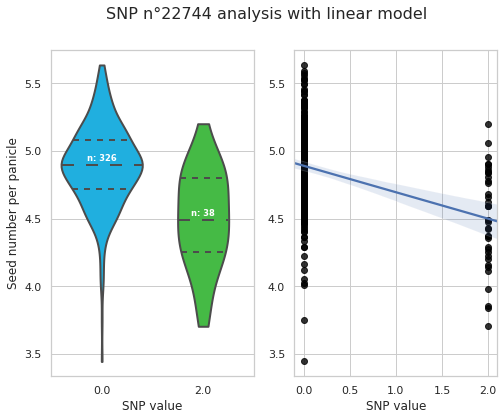

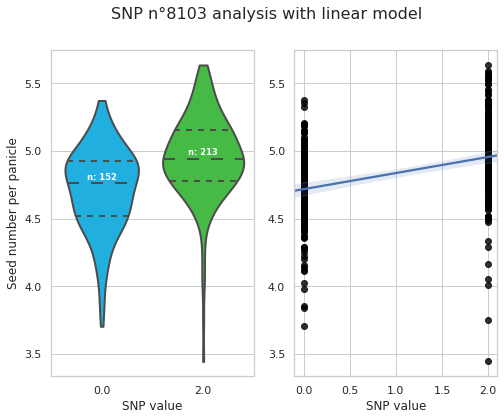

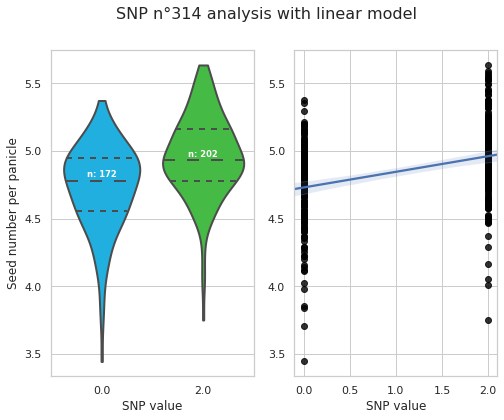

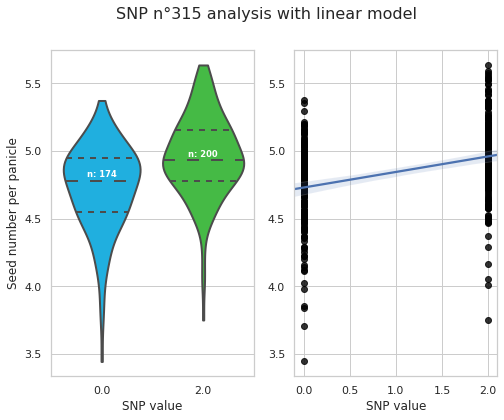

In [220]:
bestpvalues_seed = getBestPValues(df1["pvalue"],15,7)
for pv, idx in bestpvalues_seed[:5]:
    plotPhenoGeno2(idx,cols[0])
bestpvalues_seed = [i[1] for i in bestpvalues_seed]

### Best SNPs regarding their p-value for seed number

In [221]:
print(bestpvalues_seed)

[22751, 22743, 8102, 313, 314, 8152, 336, 17253, 8136, 22750, 17268, 8157, 331, 36366, 26979, 387, 341, 8138, 26993, 11661, 8103, 10429, 10437, 11648, 22753, 3278, 339, 603, 344, 17101, 320, 643, 319, 18376, 330, 17105, 17260, 338, 411, 335, 17084, 17100, 325, 25476, 708, 34699, 5232, 324, 101, 17068, 18373, 8126, 8130, 8132, 8139, 540, 10436, 531, 14745, 340, 26998, 26976, 412, 15707, 240, 570, 17256, 17271, 8623, 478, 15033, 17111, 545, 14756, 345, 8143, 641, 398, 8625, 143, 14752, 17116, 7963, 114, 326, 651, 518, 416, 447, 24417, 408, 15722, 28453, 17243, 34698, 25892, 138, 8124, 15723, 25612, 480, 29985, 4167, 3273, 8117, 400, 463, 7964, 25611, 4156, 14771, 4200, 8332, 315, 33576, 21467, 417, 142, 346, 323, 448, 15639, 470, 461, 423, 8129, 8141, 17118, 8147, 9299, 26000, 598, 8626, 25484, 14768, 468, 15724, 429, 409, 25888, 20937, 462, 23650, 10215, 460, 594, 703, 28360, 24514, 591, 18235, 704, 95, 25899, 229, 24752, 8324, 5787, 5831, 30837, 431, 17802]


### Model to identify groups

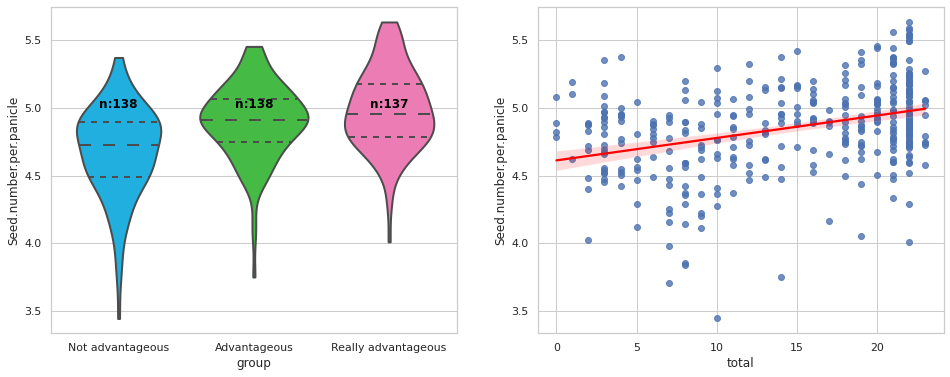

In [235]:
data_seed = identifyGroupsBasedOnAdv(bestpvalues_seed[:30],trait="Seed.number.per.panicle",nbGroups=3)

In [236]:
data_seed[["Seed.number.per.panicle","group"]].groupby('group').describe()

Seed.number.per.panicle                                \
                                      count      mean       std       min   
group                                                                       
Not advantageous                      129.0  4.680269  0.334050  3.444682   
Advantageous                          122.0  4.901340  0.277077  3.751183   
Really advantageous                   125.0  4.987658  0.295543  4.010634   

                                                             
                          25%       50%       75%       max  
group                                                        
Not advantageous     4.491441  4.728125  4.897840  5.372703  
Advantageous         4.746906  4.907618  5.068117  5.454609  
Really advantageous  4.787492  4.957746  5.177091  5.635114

## Amylose content

In [77]:
df2 = pd.read_csv(f"manhattan_{cols[1].replace('.','_')}.csv")
df2.head()

,Unnamed: 0,gene,pvalue,chromosome
0,0,id1000001,1.122855e-18,ch-1
1,1,id1000003,7.351062e-19,ch-1
2,2,id1000005,3.505632e-13,ch-1
3,3,id1000007,5.301458e-04,ch-1
4,4,id1000008,2.629448e-18,ch-1


6.567038135497739


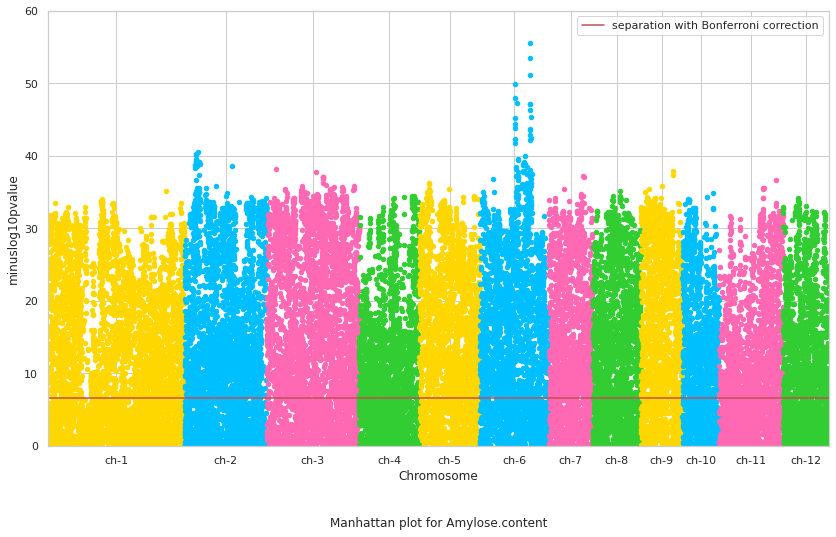

In [17]:
plotManhattan(
        df2['gene'],
        df2['pvalue'],
        df2['chromosome'],
        title=f"Manhattan plot for {cols[1]}",
        colname=cols[1],
        ymax=60)

### Best SNPs regarding their p-value for amylose content

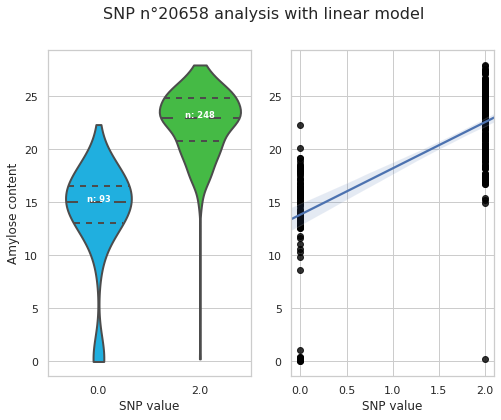

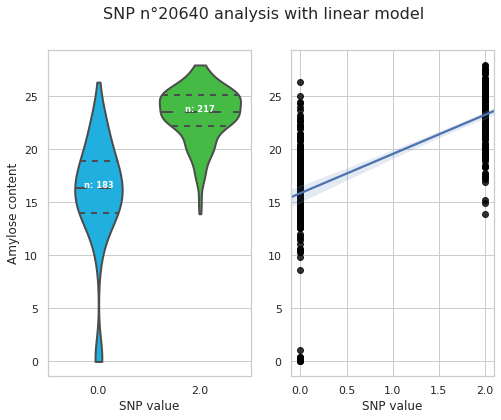

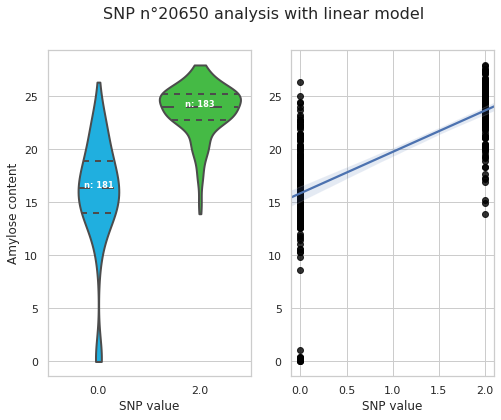

In [195]:
bestpvalues_amylose = getBestPValues(df2["pvalue"],60,40)
for pv, idx in bestpvalues_amylose[:3]:
    plotPhenoGeno2(idx,cols[1])
bestpvalues_amylose = [i[1] for i in bestpvalues_amylose]

In [193]:
print(bestpvalues_amylose)

[20657, 20639, 20649, 20924, 20927, 20921, 20654, 20653, 20655, 20637, 20943, 20941, 20938, 20645, 20644, 20652, 20669, 20926, 20656, 20929, 8405, 8539, 8542]


### Model to identify groups

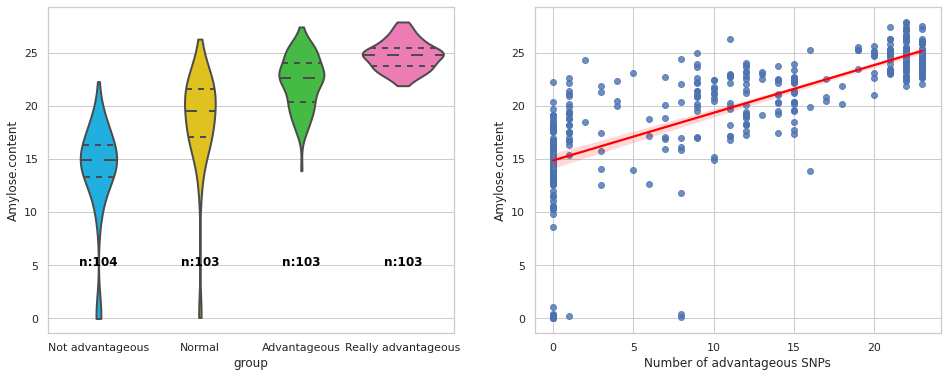

In [247]:
data_amylose = identifyGroupsBasedOnAdv(bestpvalues_amylose,trait="Amylose.content",nbGroups=4)

In [238]:
data_amylose[["Amylose.content","group"]].groupby('group').describe()

Amylose.content                                          \
                              count       mean       std     min        25%   
group                                                                         
Not advantageous              103.0  13.958689  4.628461   0.000  13.295000   
Normal                        101.0  18.764597  4.748545   0.095  17.143333   
Advantageous                   99.0  22.326047  2.500919  13.930  20.421667   
Really advantageous            98.0  24.802262  1.362522  21.950  23.809167   

                                                      
                           50%        75%        max  
group                                                 
Not advantageous     14.920000  16.381667  22.336667  
Normal               19.515000  21.616667  26.340000  
Advantageous         22.653333  24.045833  27.486667  
Really advantageous  24.844167  25.507083  27.956667

## Straighthead susceptability

In [20]:
df3 = pd.read_csv(f"manhattan_{cols[2].replace('.','_')}.csv")
df3.head()

,Unnamed: 0,gene,pvalue,chromosome
0,0,id1000001,3.358960e-11,ch-1
1,1,id1000003,1.543599e-11,ch-1
2,2,id1000005,1.741373e-04,ch-1
3,3,id1000007,2.207716e-06,ch-1
4,4,id1000008,2.076456e-11,ch-1


6.567038135497739


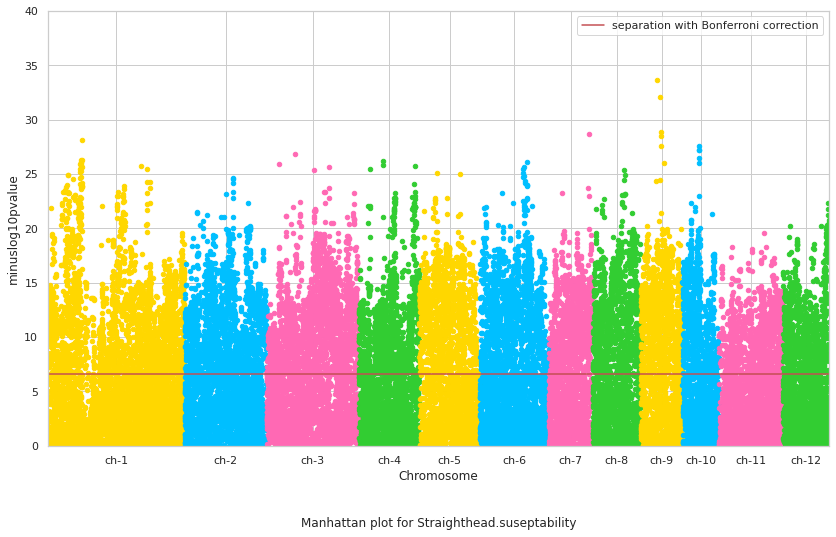

In [21]:
plotManhattan(
        df3['gene'],
        df3['pvalue'],
        df3['chromosome'],
        title=f"Manhattan plot for {cols[2]}",
        colname=cols[2],
        ymax=40)

### Best SNPs regarding their p-value for Straighthead susceptability

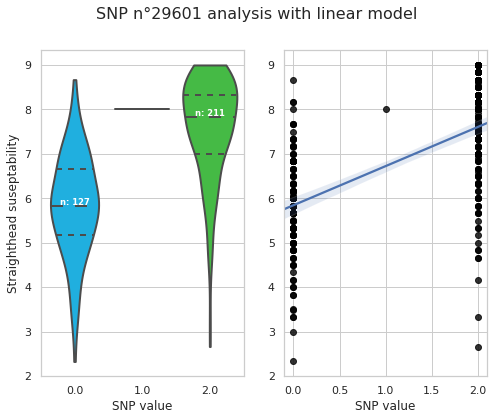

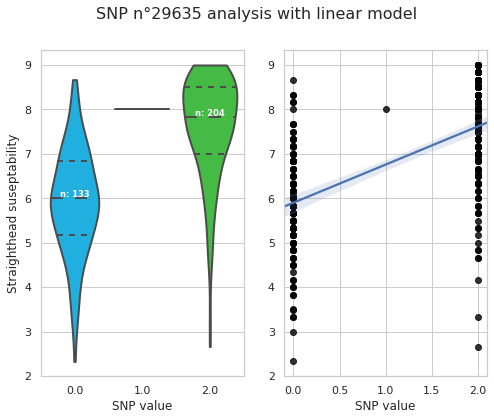

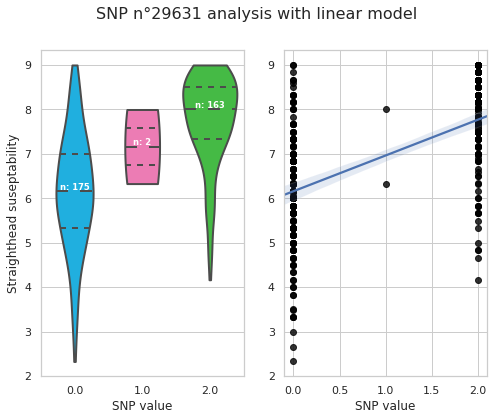

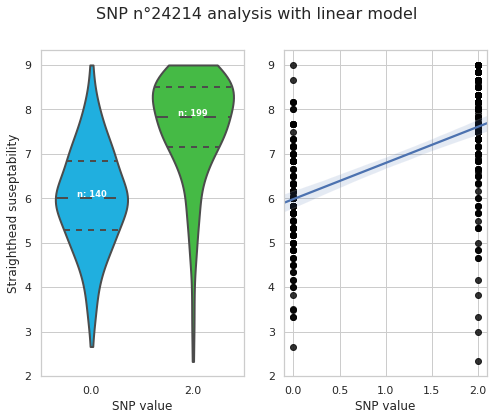

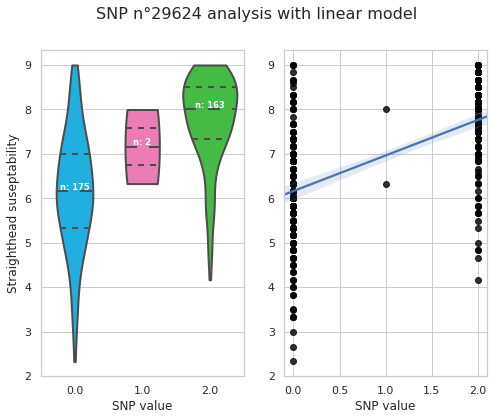

In [196]:
bestpvalues_head = getBestPValues(df3["pvalue"],35,25)
for pv, idx in bestpvalues_head[:5]:
    plotPhenoGeno2(idx,cols[2])
bestpvalues_head = [int(i[1]) for i in bestpvalues_head]

In [197]:
print(bestpvalues_head)

[29600, 29634, 29630, 24213, 29623, 3776, 29621, 31445, 31449, 31444, 14254, 31448, 3769, 3756, 17000, 3758, 20508, 28377, 3787, 31447, 12665, 3804, 17001, 3763, 15456, 146, 20514, 10451, 3771, 3759, 496, 20542, 16188, 3799, 25769, 11122, 3757, 3831, 20541, 20073]


### Model to identify groups

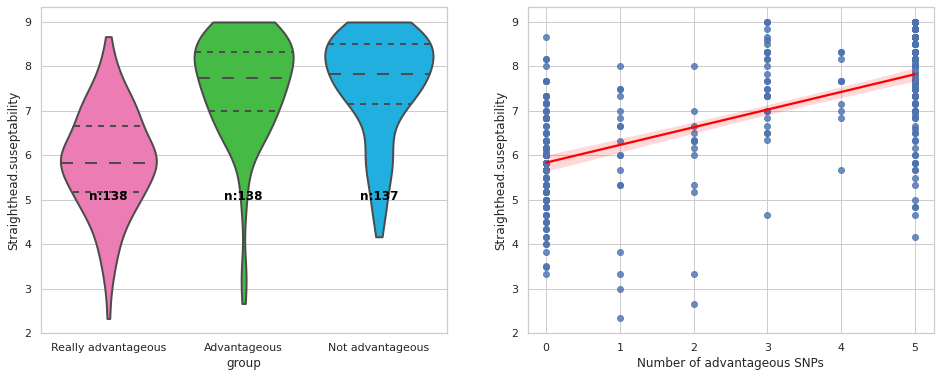

In [246]:
data_head = identifyGroupsBasedOnAdv(
    bestpvalues_head[:5],
    trait="Straighthead.suseptability",
    nbGroups=3,
    isHigherAdvantageous=False
)

In [243]:
data_head[["Straighthead.suseptability","group"]].groupby('group').describe()

Straighthead.suseptability                                \
                                         count      mean       std       min   
group                                                                          
Really advantageous                      129.0  5.868966  1.148517  2.330000   
Advantageous                             118.0  7.583164  1.191636  2.666667   
Not advantageous                          93.0  7.593297  1.151102  4.168333   

                                                      
                          25%    50%       75%   max  
group                                                 
Really advantageous  5.166667  5.835  6.670000  8.67  
Advantageous         6.998750  7.750  8.333333  9.00  
Not advantageous     7.165000  7.835  8.498333  9.00